In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
df = pd.read_csv('Data/insurance - insurance.csv')
df.head(2)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523


## Q1. Do smokers have higher insurance charges than non-smokers?

"Null Hypothesis ": There is no significant difference between the charge of smokers and non_smokers

"Alternate Hypothesis": There is significant difference between the charge of smokers and non_smokers.

alpha is 0.05.

The test type is: two sample T-test.

In [4]:
#creates a random sample of 50, and splits the data based on smokers or non_smoker. 
#The length and mean of each group is printed.
sample = df.sample(n=50,random_state=42)
smokers_charge = sample.loc[ sample['smoker']=='yes',"charges"]
non_smokers_charge = sample.loc[ sample['smoker']=='no',"charges"]
## Getting means for charges
print(f"For smokers (n={len(smokers_charge)}): Mean={np.mean(smokers_charge):.2f}")
print(f"For non_smokers (n={len(non_smokers_charge)}): Mean={np.mean(non_smokers_charge):.2f}")

For smokers (n=11): Mean=35439.40
For non_smokers (n=39): Mean=7309.48


## Test the assumptions

Independent T-Test(2 samples) Assumptions:

No significant outliers


Normality 

Equal Variance

In [5]:
# test each group outliers
np.sum(abs(stats.zscore(smokers_charge))>3)

0

In [6]:
np.sum(abs(stats.zscore(non_smokers_charge))>3)

0

There are no outliers in our data.

In [7]:
#test each group normality
# normal test smokers
result_s = stats.normaltest(smokers_charge)
result_s

C:\Users\qfu88\anaconda3\envs\dojo-env\lib\site-packages\scipy\stats\_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


NormaltestResult(statistic=2.209358578032982, pvalue=0.331317122245031)

In [8]:
#normal test non_smokers
result_n = stats.normaltest(non_smokers_charge)
result_n

NormaltestResult(statistic=2.6262187199374125, pvalue=0.26898239167805005)

For both the smoker and non_smoker groups, the p-value is greater than 0.05. so we can assume these two groups are normal distributions.

In [9]:
#Testing for Equal Variance with Levene's test
result = stats.levene(smokers_charge, non_smokers_charge)
result

LeveneResult(statistic=18.397400827816167, pvalue=8.621214599569032e-05)

So the p-value is greater than 0.05. we met this assumptions.

## Execute the selected test

In [10]:
result = stats.ttest_ind(smokers_charge,non_smokers_charge)
result

Ttest_indResult(statistic=13.237119558105961, pvalue=1.2286151200596125e-17)

so our p value < 0.05. we reject the null hypothesis and accept there is a significant difference between the charges of smokers and non_smokers. 

## Q2. Are men more likely to smoke than women?

"Null Hypothesis ": the probabiity of men smoke >0.5.

"Alternate Hypothesis": the probability of men smoke is <=0.5.

alpha is 0.05.

The test type is: Binomial Test.

## Test the assumptions

There are 2 possible outcomes: success and failure. 


The probability of success is constant.

The trials are independent (outcome of one trial does not influence another)

In [18]:
male_smoker = df.loc[(df['sex']=="male")&(df['smoker']=="yes")]
len(male_smoker)

159

In [19]:
female_smoker = df.loc[(df['sex']=="female")&(df['smoker']=="yes")]
len(female_smoker)

115

In [25]:
# Save outcomes of 159 males (success), 115 females (failure)
outcomes = [159,115]
p_value = stats.binom_test(outcomes,p=0.5, alternative='greater') # p is the expected probability of success (heads)
p_value

0.004629969384357161

The p_value is <0.05. we rejected the null hypothesis that the probability of men smoke >0.5. we can conclude that men is not more likely to smoke than women.

## Q3. Do different regions have different charges, on average?

"null hypothesis": all regions' average charge are the same.

"alternate hypothesis":there is a difference between the regions' averge charge.

Using an alpha=.05

The test type is: one way ANOVA


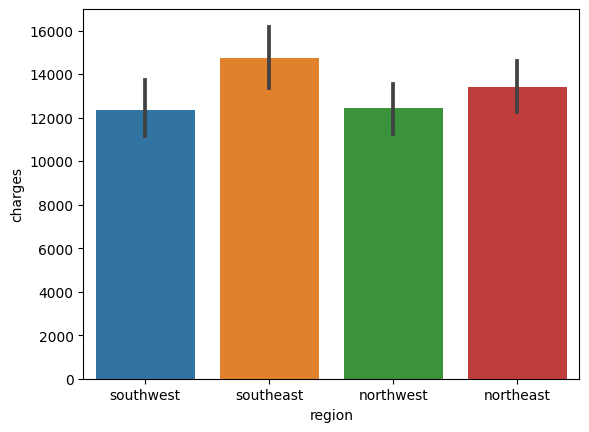

In [26]:
#visulize the different regions' charges.
sns.barplot(data=df, x='region',y='charges');

In [27]:
## separating our regions
regions = {}
## Loop through all unique categories
for i in df['region'].unique():
    data = df.loc[df['region']==i,'charges'].copy()
    
    # save into the dictionary
    regions[i] = data
regions.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

## Test the assumptions

No significant outliers

Equal variance

Normality

In [29]:
## test the outliers
charges = df['charges']
np.sum(abs(stats.zscore(charges))>3)

7

In [30]:
# remove outliers
charges = charges[(np.abs(stats.zscore(charges)) < 3)]

In [31]:
## test the normality
## Running normal test on each region and confirming there are >20 in each region
norm_results = {}
for i, data in regions.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df


,n,p,test stat
southwest,325.0,6.125298e-23,102.294059
southeast,364.0,4.953297e-15,65.877446
northwest,325.0,5.184209e-24,107.232850
northeast,324.0,1.455431e-19,86.747629


In [32]:
### checking sig with pandas 
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df

,n,p,test stat,sig
southwest,325.0,6.125298e-23,102.294059,True
southeast,364.0,4.953297e-15,65.877446,True
northwest,325.0,5.184209e-24,107.232850,True
northeast,324.0,1.455431e-19,86.747629,True


we can confirm that non of the regions have normal distribution. But each region's size is large enough, so we can ignore the assumption result of normality.

In [33]:
#Testing Assumption of Equal Variance 
stats.levene(*regions.values())

LeveneResult(statistic=5.559966758410606, pvalue=0.0008610590250786703)

we can see that I fail the assumption of equal variance. I will choose a different test: Kruskal-Wallis

In [34]:
#perform the test
result = stats.kruskal( *regions.values())
result

KruskalResult(statistic=4.734181215658743, pvalue=0.19232908072121002)

The pvalue is >0.05, so there is no significant difference charges between the regions.